# Neural Network from Scratch in Python

In [1]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## 1 Layer, 1 Neuron Neural Network, OR logic gate
What goes on inside a perceptron?

$z = \mathbf{w} \cdot \mathbf{x} + b = w_0x_0 + w_1x_1 + b$

We introduce non-linearity to the system using the sigmoid function i.e.
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

### Backpropagation
The problem regards how we actually update the weights of each neuron in the system. A common method utilises what is called the _gradient descent_ algorithm.
This involves updating the weights of each neuron, every epoch we train the model. A hyperparameter $\eta$ is introduced which is commonly called the _learning rate_ (LR) or occassionally _mixing parameter_.

$
\begin{equation}
\mathbf{w}' = \mathbf{w} - \eta \frac{\partial E}{\partial \mathbf{w}}
\end{equation}
$

We use the chain rule to solve $\frac{\partial E}{\partial \mathbf{w}}$ i.e.
$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial \mathbf{w}}
\end{equation}$

Solving each term (assuming the Error Function is MSE here and activation function is sigmoid in this case):
$\begin{equation}
\frac{\partial E}{\partial a} = \frac{\partial}{\partial a}\frac{1}{2} (y - a)^2 = a - y
\end{equation}$

$\begin{equation}
\frac{\partial a}{\partial z} = \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1 - \sigma(z))
\end{equation}$

$\begin{equation}
\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial}{\partial \mathbf{w}} \mathbf{w} \cdot \mathbf{x} + b = \mathbf{x}
\end{equation}$

which finally gives us

$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = (a - y) \times \sigma(z)(1 - \sigma(z)) \times \mathbf{x}
\end{equation}$

and finally what about the bias?

$\begin{equation}
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}
\end{equation}$

We know most of these terms except the last

$\begin{equation}
\frac{\partial z}{\partial b} = \frac{\partial}{\partial b} \mathbf{w} \cdot \mathbf{x} + b = 1
\end{equation}$

and so, finally

$\begin{equation}
\frac{\partial E}{\partial b} = (a - y) \times \sigma(z)(1 - \sigma(z))
\end{equation}$

In [2]:
class ActivationFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    @abstractmethod
    def derivative(self):
        pass

class ErrorFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    def derivative(self):
        pass

In [313]:

@dataclass
class Sigmoid(ActivationFunction):
    name: str = 'sigmoid'

    def function(self, x):
        return 1/(1 + np.exp(-x))
    
    def derivative(self, x):
        return self.function(x)*(1-self.function(x))
    
@dataclass 
class MeanSquaredError(ErrorFunction):
    name: str = 'MSE'

    def function(self, a, y):
        return 0.5*(y - a)**2
    
    def derivative(self, a, y):
        return (a - y)

@dataclass
class Neuron():
    input_shape: int
    activation_function: ActivationFunction
    weights: np.ndarray[np.float64] = None
    bias: float = np.random.rand(1)
    error: float = 0
    delta: np.ndarray = np.array([])
    delta_weights: np.ndarray = np.array([])
    weights_gradient = 0
    bias_gradient = 0
    z: float = None
    a: float = None
    inputs = None

    def __post_init__(self):
        """Initialise the weights. We do this post_initialisation because we depend
        on the input shape.
        """
        self.weights = np.random.rand(self.input_shape)

    def forward(self, x: np.ndarray) -> float:
        self.inputs = x
        self.z = np.dot(self.weights, x) + self.bias
        self.a = self.activation_function.function(self.z)

        return self.a
    
    def backward(self, delta: np.ndarray):
        self.error = delta * self.activation_function.derivative(self.z)
        self.weights_gradient +=  np.outer(delta, self.inputs)
        self.bias_gradient += delta

        return self.error
    
    def update_weights(self, lr=0.05):
        self.weights -= (np.squeeze(self.weights_gradient) * lr)
        self.bias -= ( self.bias_gradient * lr)

        self.weights_gradient = 0
        self.bias_gradient = 0


In [4]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y = [0, 1, 1, 1]

In [5]:
n1 = Neuron(2, Sigmoid())
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a = n1.forward(x)
    E = 0.5*(y - a)**2
    E_prime = (a - y)

print(E_prime)

-0.11344469587120076


In [6]:
n1.input_shape

2

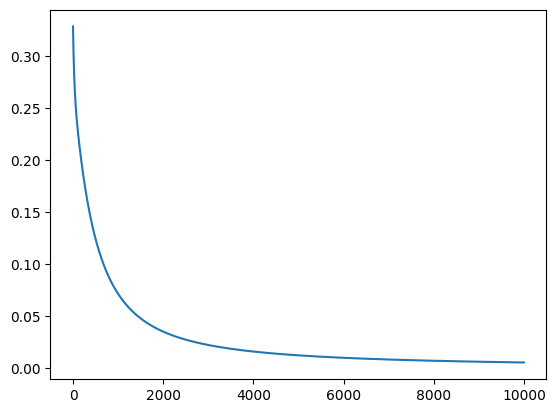

In [173]:
n1 = Neuron(2, Sigmoid())
all_E = []
for i in range(10000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a = n1.forward(x)
        E += 0.5*(y - a)**2
        E_prime = (a - y)
        delta = n1.backward(E_prime)

        n1.update_weights()
    all_E += [E]

plt.figure()
plt.plot(all_E)
plt.show()

In [324]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())

In [325]:
w0 = n0.weights
b0 = n0.bias
w1 = n1.weights
b1 = n1.bias

lr = 0.05

for i in range(10000):
    del_w0 = 0
    del_b0 = 0
    del_w1 = 0
    del_b1 = 0
    C = 0
    for x, y in zip(X, Y):
        z0 = np.dot(x, w0) + b0
        a0 = Sigmoid().function(z0)

        z1 = np.dot(a0, w1) + b1
        a1 = Sigmoid().function(z1)

        C += 0.5*(y - a1)**2

        delta = (a1 - y) * Sigmoid().derivative(z1)
        del_w1 += np.dot(delta, np.transpose(a0))
        del_b1 += delta

        delta_0 = np.dot(np.transpose(w1), delta) * Sigmoid().derivative(z0)

        del_w0 += np.outer(delta_0, np.transpose(x))
        del_b0 += delta_0
    if np.mod(i, 1000) == 0:
        print('Epoch: %d - %f\r' % (i, C/4), end='')
    break

    w0 -= (lr/4) * np.squeeze(del_w0)
    b0 -= (lr/4) * del_b0
    w1 -= (lr/4) * del_w1
    b1 -= (lr/4) * del_b1

In [326]:
del_w1

-7.105026554555106e-05

In [327]:
all_E = []
for i in range(1000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = n0.forward(x)
        a1 = n1.forward(a0)
        E += 0.5*(y - a1)**2
        E_prime = (a1 - y)
        #d1 = n1.backward(E_prime)
        #d1 = E_prime * n1.activation_function.derivative(n1.z)
        #n1.delta = np.append(n1.delta, d1)
        d1 = n1.backward(E_prime)
        d0 = n0.backward(np.dot(n1.weights.T, d1))


    n1.update_weights(lr=0.5)
    n0.update_weights(lr=0.5)
    all_E += [E]


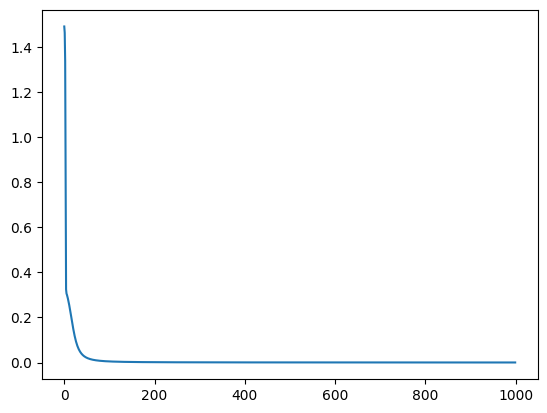

In [329]:
plt.figure()
plt.plot(all_E)
plt.show()

In [332]:
x = np.array([0, 0])
y = np.array(y)

a0 = n0.forward(x)
a1 = n1.forward(a0)

print(a1)

[0.01316966]


In [350]:
@dataclass
class Layer():
    num_neurons: int
    activation: ActivationFunction
    input_shape: np.ndarray = None
    neurons: List[Neuron] = None
    inputs: np.ndarray = None
    previous_layer: 'Layer' = None

    # Note, we make the weights a property to retain the vectorizability.
    @property
    def weights(self):
        return np.array([n.weights for n in self.neurons])
    
    @weights.setter
    def weights(self, weights):
        for w, n in zip(weights, self.neurons):
            n.weights = w

    # TODO these probably don't need to be properties
    @property
    def a(self):
        return np.array([n.a for n in self.neurons])
    
    @property
    def z(self):
        return np.array([n.z for n in self.neurons])
    
    @property
    def error(self):
        return np.array([n.error for n in self.neurons])
    
    @property
    def delta(self):
        return np.array([n.delta for n in self.neurons])
    
    @property
    def l_inputs(self):
        return np.array([n.inputs for n in self.neurons])

    def __post_init__(self):
        if self.input_shape is not None:
            self.initialise_layer()

    def __call__(self, layer):
        self.input_shape = layer.num_neurons
        self.initialise_layer()
        self.previous_layer = layer
        return self
    
    def initialise_layer(self):
        self.neurons = [Neuron(self.input_shape, self.activation) for _ in range(self.num_neurons)]

    def forward(self, x):
        self.inputs = x
        for n in self.neurons: n.forward(x)
        return self.a
    
    #def backward(self, error, previous_output, lp1 = None):
    #    [n.backward(error, p) for n, p in zip(self.neurons, previous_output)]
    #    if lp1 is not None:
    #        error = compute_error_term(self, lp1)
    #        return error
        
    def backward(self, error_term):
        for n, delta in zip(self.neurons, error_term): 
            n.backward(delta)

    def update_weights(self, lr=0.05):
        for n in self.neurons:
            n.update_weights(lr)

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error

In [351]:
l0 = Layer(2, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=2, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.8398466 , 0.20159278]), bias=array([-5.80134561]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.95636918, 0.46299709]), bias=array([-5.80134561]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None)], inputs=None, previous_layer=None)
Layer(num_neurons=2, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.5146391 , 0.97380599]), bias=array([-5.80134561]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.08736743, 0.81466181

In [335]:
x = np.array([1, 1])
y = np.array([1])

a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

E = 0.5*(y - o)**2
print(E)
E_prime = (o - y)

[[0.48882817]]


In [336]:
a0, l1.inputs

(array([[0.04331951],
        [0.01738947]]),
 array([[0.04331951],
        [0.01738947]]))

In [337]:
output.backward(E_prime)
l1.backward(np.dot(output.weights.T, output.error))
l0.backward(np.dot(l1.weights.T, l1.error))

In [338]:
output.error

array([[-0.01098391]])

In [339]:
l0.weights

array([[0.84008295, 0.55689552],
       [0.36840343, 0.0890935 ]])

In [340]:
output.update_weights()
l1.update_weights()
l0.update_weights()

c:\Users\David\miniconda3\envs\artify310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\David\miniconda3\envs\artify310\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\David\miniconda3\envs\artify310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [341]:
l0.weights

array([[0.84008521, 0.55689777],
       [0.36840784, 0.08909791]])

# Testing implementation

In [342]:
l0 = Layer(1, Sigmoid(), 2)
print(l0)
l1 = Layer(1, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=1, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.76436528, 0.90396459]), bias=array([-4.44170057]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None)], inputs=None, previous_layer=None)
Layer(num_neurons=1, activation=Sigmoid(name='sigmoid'), input_shape=1, neurons=[Neuron(input_shape=1, activation_function=Sigmoid(name='sigmoid'), weights=array([0.52724385]), bias=array([-4.44170057]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None)], inputs=None, previous_layer=Layer(num_neurons=1, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.76436528, 0.90396459]), bias=array([-4.44170057]), error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None)], input

In [343]:
all_E = []

for i in range(100000):
    epoch_E = []
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)
        a0 = l0.forward(x)
        a1 = l1.forward(a0)
        o = output.forward(a1)

        E = 0.5*(y - o)**2
        epoch_E += [E]
        E_prime = (o - y)

        output.backward(E_prime)
        l1.backward(np.dot(output.weights.T, output.error))
        l0.backward(np.dot(l1.weights.T, l1.error))
    all_E += [np.mean(epoch_E)]
    print(all_E[-1])
    
    output.update_weights(lr=0.05)
    l1.update_weights(lr = 0.05)
    l0.update_weights(lr = 0.05)

0.36623803851422676
0.36483939217326294
0.3632210522232994
0.36134973939749
0.3591875607735128
0.3566915245394379
0.35381306591012107
0.35049761822193465
0.3466842813495642
0.3423056659344051
0.33728802984625617
0.3315518769721747
0.32501326218814774
0.3175861429446734
0.3091862341445888
0.29973694142143403
0.2891780219231114
0.27747755407518016
0.2646474193929725
0.25076157266421145
0.2359746804968899
0.22053628431246977
0.20479322740629263
0.18917246173822855
0.17413991085363165
0.16013981511505077
0.14752981519457428
0.13653271969854303
0.1272205776961841
0.11953252668500552
0.1133144206835551
0.10836351580044622
0.10446561156848452
0.1014195226960827
0.09904960234645668
0.09720965738177724
0.09578180017758993
0.09467291891622653
0.09381043254755292
0.09313820758166276
0.09261301177914565
0.09220160256796466
0.09187841505564771
0.09162376300623762
0.09142245585677457
0.09126274280386801
0.09113550925400889
0.09103366585534821
0.09095168359576057
0.0908852393767978
0.0908309450986921

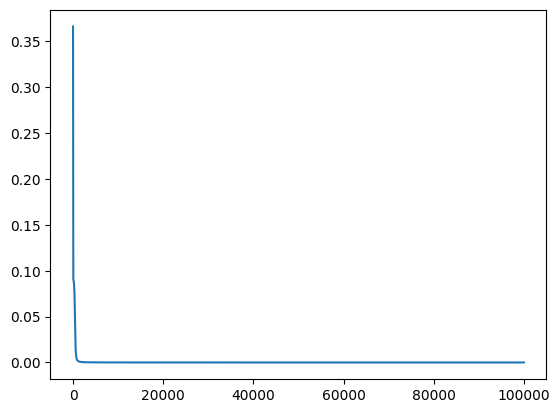

In [344]:
plt.figure()
plt.plot(all_E)
plt.show()

In [347]:
x = np.array([1, 1])

a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

print(o)

[[0.99999999]]
